In [23]:
master='local[*]'

file_regression='/home/ggomarr/Documents/Education/Udemy_Spark/44_regression.txt'

In [26]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('DataframesAndMllib').getOrCreate()
sc=spark.sparkContext

from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors

In [73]:
def extract_data(data_row):
    data=data_row.split(',')
    return (float(data[0]),Vectors.dense(float(data[1])))

In [74]:
ratings_df=(sc.textFile(file_regression)
              .map(extract_data)
              .toDF(['label','features']))

In [75]:
ratings_df.show(5)

+-----+--------+
|label|features|
+-----+--------+
|-1.74|  [1.66]|
| 1.24| [-1.18]|
| 0.29|  [-0.4]|
|-0.13|  [0.09]|
|-0.39|  [0.38]|
+-----+--------+
only showing top 5 rows



In [57]:
from pyspark.sql import functions,Row
from pyspark.sql.types import StructType, StructField, FloatType

schema=StructType([StructField("label", FloatType()),
                   StructField("x", FloatType())])
ratings_df_2=spark.read.csv(file_regression,sep=',',schema=schema)
ratings_df_2.rdd.map(lambda r: Row(label=r['label'],features=Vectors.dense(r['x']))).toDF().show(5)

+--------------------+--------------------+
|            features|               label|
+--------------------+--------------------+
| [1.659999966621399]| -1.7400000095367432|
|[-1.1799999475479...|  1.2400000095367432|
|[-0.4000000059604...| 0.28999999165534973|
|[0.09000000357627...|-0.12999999523162842|
|[0.3799999952316284]|-0.38999998569488525|
+--------------------+--------------------+
only showing top 5 rows



In [76]:
train_df,test_df=ratings_df.randomSplit([0.8,0.2])
train_df.show(5)

+-----+--------+
|label|features|
+-----+--------+
|-3.74|  [3.75]|
|-2.58|  [2.57]|
|-2.36|  [2.63]|
|-2.29|  [2.35]|
|-2.27|  [2.19]|
+-----+--------+
only showing top 5 rows



In [77]:
regression_model=LinearRegression(maxIter=10,regParam=0.3,elasticNetParam=0.8).fit(train_df)
test_predictions=regression_model.transform(test_df).cache()

In [80]:
test_predictions.show(5)

+-----+--------+-------------------+
|label|features|         prediction|
+-----+--------+-------------------+
|-2.54|  [2.39]|-1.7138593392651367|
|-1.91|  [1.83]|-1.3148382695625032|
|-1.58|  [1.65]| -1.186581497158085|
|-1.36|  [1.41]| -1.015572467285528|
|-1.29|  [1.14]|-0.8231873086789009|
+-----+--------+-------------------+
only showing top 5 rows



In [83]:
from pyspark.mllib.evaluation import RegressionMetrics
rm=RegressionMetrics(test_predictions.select(['prediction','label']).rdd)
rm.rootMeanSquaredError

0.29771144184820164

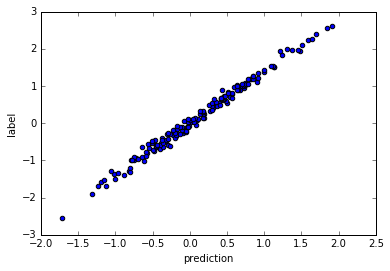

In [104]:
(test_predictions.toPandas()
                 .plot(kind='scatter', x='prediction', y='label'))